In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KernelDensity
import scipy
import utils
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

To download the AnnData object with the scRNA data, go to:
https://drive.google.com/file/d/1h2UESiQBIg8lIaLB_bp1-nLPfn1Y54zF/view?usp=sharing
(must have lionmail; email lf2684@columbia.edu if there are access issues).
To download the inferCNV object, go to:
https://drive.google.com/file/d/1d-r2Cp0cdpaV6G6zPIOsuvA50E0pJrUK/view?usp=sharing

# Premise

We are building off single cell Hierarchial Poisson
Factorization, a way of uncovering latent
information from a cell by gene matrix of gene expression
counts. Below is the model discussed
in 'De novo gene signature identification from single-cell
RNA-seq with hierarchical Poisson factorization' (Yuan et. al.).
This uses hierarchial gamma priors and samples from a final
Poisson distribution

![alt text](orig_model_diagram.png)

# Data

This method has the issue that it doesn't take into
account all available data. By modeling cells and genes
separately, it fails to make use of the single-cell
resolution of gene expression. It also doesn't consider
copy number variations, which are changes in the number of
copies of each gene in the chromosome itself.

We utilize single cell copy number alteration data generated from
inferCNV. This data can be broken down into three large groups: genes
that are amplified, deleted, or unchanged. As you can see from the below
histogram, there are discrete boundaries between each of the three states,
but the modes of each state are relatively close together. The boundaries
delineating each state are pre-defined as <.95=deletion, >1.05=amplification,
and anything in between is no change.

In [2]:
infer = pd.read_csv("N_infer_full_10.16.21", index_col=0)

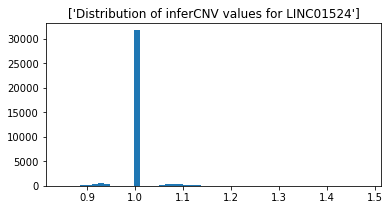

In [3]:
fig = plt.figure(figsize=(6, 3))
gene = np.random.choice(infer.columns, size=1)
plt.hist(infer[gene], bins=50)
plt.title("Distribution of inferCNV values for " + gene)
plt.show()

# Model

In consultation with Dr. Elham Azizi, we selected the below
model to incorperate the copy number variations. The left hand
side of the model, which deals exclusivly with cell based
changes, remains the same as the original scHPF model. However, we
modified the plating of the right side of the model to be able to
fit gene expression at the single cell level, and by extension, would
extend to single cell copy number variation. To model the copy number
state, we elected for a gaussion mixture model, which had the potential
to reduce the heavy variance in the data. Further, because we know the
cutoff values for each state, we were able to fix the means of the
three mixture components prior to training (one for each of the deletion,
no change, and amplification states). The means of the mixture component
to which each cell and gene pair are assigned are then used
as input to the next hierarchical layer, which we converted to a gaussian
(from the initial gamma) to be able to incorporate the means.

![alt text](our_model_small.png)

## Data considerations

In [14]:
adata = sc.read_h5ad("N_ribas310_clones.h5")

We subsample from the AnnData object such that we have proportional
representation of the four previously defined copy number clones but
reducing the number of cells. We also reduce the number of genes by
selecting the top 200 highly varying genes

In [15]:
adata_subsampled, infer_subsampled = utils.format_data(adata, infer, 200, 200)

Trying to set attribute `.uns` of view, copying.


... storing 'celltype_bped_fine' as categorical
... storing 'celltype_iced_main' as categorical
... storing 'celltype_iced_fine' as categorical
... storing 'celltype_hpca_main' as categorical
... storing 'celltype_hpca_fine' as categorical
... storing 'celltype_mid_main' as categorical
... storing 'celltype_mid_fine' as categorical


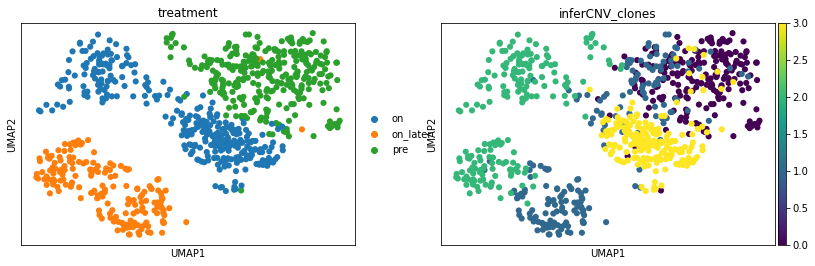

In [16]:
sc.pl.umap(adata_subsampled, color=["treatment", "inferCNV_clones"])

In [17]:
small_infer = infer_subsampled.tolist()

In [18]:
GMM_fit = utils.run_gmm("GMM.stan", small_infer)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/lf2684/notebooks/pp_project/GMM
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


# Mixture Model Box's Loop

We decided on a gaussian mixture model where we pre set the means of each
gaussian. But this was not our first idea.

## Gamma mixture

Our initial model utilized a gamma mixture to maintain
conditional conjugacy throughout the model. However, because
of an inability to pre-set the means, the model was not able to
represent the tri-modality of the data. We could not construct
a Gamma mixture model with small enough
variance to isolate all three distributions.

## Gaussian mixture


Contrary to the aforementioned approach of fixing the means of
the three mixture model components, we had initially attempted
a Gaussian mixture model that allowed the model to choose the means
of each distribution. Even with strong priors, however, this model
was not able to select means that corresponded well with our prior
knowledge.

Thus, the final model relies on pre-set mixture means, where each of
the three means correspond to the mean inferCNV value for cell and gene
pairs falling within each of the three copy number alteration states. As
evident in the KDE plots shown below, this version of the model gives
a superior fit to the given data.

In [19]:
vp_dict = GMM_fit.variational_params_dict
pi = [vp_dict['pi[1]'], vp_dict['pi[2]'], vp_dict['pi[3]']]
sigma = [vp_dict['sigma[1]'], vp_dict['sigma[2]'], vp_dict['sigma[3]']]
mu = [.9109, 1.001, 1.1167]

mixture = np.zeros(infer_subsampled.shape)

for c in range(len(small_infer)):
    for g in range(len(small_infer[0])):
        probs = []
        for i in range(3):
            probs.append(np.log(pi[i]) +
                         stats.norm.logpdf(small_infer[c][g],
                                           loc=mu[i], scale=sigma[i]))
            mixture[c][g] = np.argmax(probs) + 1

flat_mixture = [item for subl in mixture for item in subl]

In [21]:
pi = [vp_dict['pi[1]'], vp_dict['pi[2]'], vp_dict['pi[3]']]
sigma = [vp_dict['sigma[1]'], vp_dict['sigma[2]'], vp_dict['sigma[3]']]
mu = [.9109, 1.001, 1.1167]
posterior_samples_closed = []
sampleList = [0, 1, 2]
randomList = random.choices(sampleList,
                            weights=(pi[0], pi[1], pi[2]), k=960000)
for dist in randomList:
    posterior_samples_closed.append(np.random.normal(loc=mu[dist],
                                                     scale=sigma[dist]))

In [22]:
posterior_samples_open = np.loadtxt("posterior_samples_open.txt")

In [23]:
flat_infer = [item for subl in infer_subsampled for item in subl]
arr = np.array(flat_infer[0:80000]).reshape(-1, 1)
kde_data = KernelDensity(kernel='gaussian',
                         bandwidth=0.01).fit(arr)

In [24]:
arr = np.array(posterior_samples_closed).reshape(-1, 1)
kde_ppc = KernelDensity(kernel='gaussian',
                        bandwidth=.01).fit(arr)

In [25]:
arr = np.array(posterior_samples_open).reshape(-1, 1)
kde_ppc_open = KernelDensity(kernel='gaussian',
                             bandwidth=.01).fit()

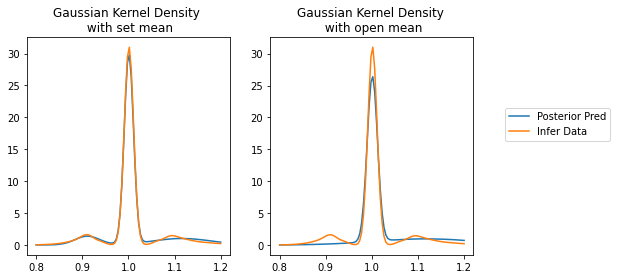

In [26]:
s = np.linspace(.8, 1.2, 100)
e_closed = np.exp(kde_ppc.score_samples(s.reshape(-1, 1)))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].set_title("Gaussian Kernel Density \n with set mean")
ax[0].plot(s, e_closed, label="Posterior Predictive")

s_data = np.linspace(.8, 1.2, 100)
e_data = np.exp(kde_data.score_samples(s_data.reshape(-1, 1)))
ax[0].plot(s_data, e_data, label="Infer Data")

e_open = np.exp(kde_ppc_open.score_samples(s.reshape(-1, 1)))

ax[1].set_title("Gaussian Kernel Density \n with open mean")
ax[1].plot(s, e_open, label="Posterior Pred")

s_data = np.linspace(.8, 1.2, 100)
e_data = np.exp(kde_data.score_samples(s_data.reshape(-1, 1)))
ax[1].plot(s_data, e_data, label="Infer Data")
ax[1].legend(bbox_to_anchor=(1.7, .7))


## Gaussian Mixture Criticism

Above are comparisons between the gaussian kernel density plots
of the model where we chose the means and where we allowed stan
to choose the means. The former demonstrates a better ability to
model the true distribution of the data.

We also applied statistical tests to assess the fit of our models.
The KS values led us to beleive that the open model fit better,
while the t-test led us to beleive the oposite. We elected to follow
the results provided by the t-test since the mixture means are of
greater importance, and because of the results seen in the KDE plots.

In [27]:
print("KS metric on kernel density smoothed model where we set means")
print(stats.ks_2samp(e_closed, e_data, mode='exact'))

KS metric on kernel density smoothed model where we set means
KstestResult(statistic=0.19, pvalue=0.05390207893129876)


In [28]:
print("KS metric on kernel density smoothed model where stan choose means")
print(stats.ks_2samp(e_open, e_data, mode='exact'))

KS metric on kernel density smoothed model where stan choose means
KstestResult(statistic=0.17, pvalue=0.11119526053829192)


In [29]:
t_closed_mean = utils.get_t_tests(posterior_samples_closed, flat_infer)
t_open_mean = utils.get_t_tests(posterior_samples_open, flat_infer)

print("The T values for chosen mean fit are")
print(t_closed_mean)
print('\n')

print("The T values for open mean fit are")
print(t_open_mean)

The T values for chosen mean fit are
[Ttest_indResult(statistic=-0.5442450378379309, pvalue=0.5862740985070083), Ttest_indResult(statistic=9.585158307421107, pvalue=9.254678695098993e-22), Ttest_indResult(statistic=17.909312457578356, pvalue=1.1742960411710419e-71)]


The T values for open mean fit are
[Ttest_indResult(statistic=20.16939109177221, pvalue=6.339790826786456e-90), Ttest_indResult(statistic=13.483941006225537, pvalue=1.9630581533467062e-41), Ttest_indResult(statistic=78.14362366666947, pvalue=0.0)]


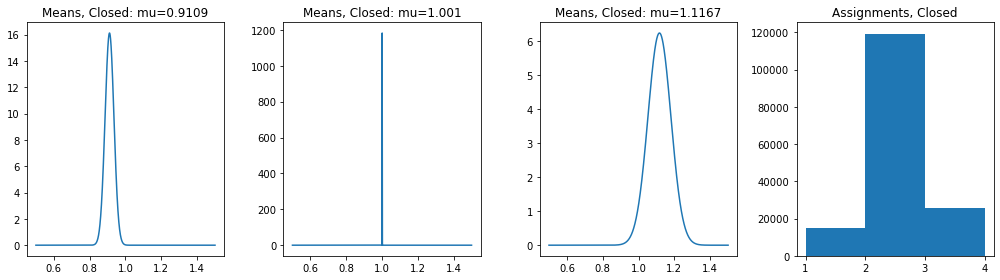

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4))
for i in range(1, 4):
    mu = [.9109, 1.001, 1.1167][i-1]
    sigma = 'sigma[' + str(i) + ']'
    x = np.linspace(.5, 1.5, 100000)
    y = stats.norm.pdf(x, loc=mu, scale=GMM_fit.variational_params_dict[sigma])
    ax[i-1].plot(x, y)
    ax[i-1].set_title("Means, Closed: mu="+str(mu))
ax[3].hist(flat_mixture, bins=[1, 2, 3, 4])
ax[3].set_title("Assignments, Closed")
plt.tight_layout()

Above are the final distributions of the closed model and
the histogram of assignments. These are very similar to
the histogram of the copy number varaition values above,
and the model correclty reduces the variance of the data.

### Modified Hierarchical Gamma/Gaussian Model
Now we initialize and run the hierarchical part of our model.
As described above, we modified this model from its initial
hierarchical Poisson form to be able to model single cell-level
gene expression.

In [30]:
X = adata_subsampled.layers['counts'].astype('int').tolist()

In [31]:
mixture_means = []
mu = [.9109, 1.001, 1.1167]
for c in range(infer_subsampled.shape[0]):
    curr = []
    for g in range(infer_subsampled.shape[1]):
        curr.append(mu[int(mixture[c][g]-1)])
    mixture_means.append(curr)

In [32]:
mod_scHPF_fit = utils.run_hpf('mod_scHPF.stan',
                              adata_subsampled, X, mixture_means)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/lf2684/notebooks/pp_project/mod_scHPF
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


### Criticism of scHPF model
We performed both biological and statistical criticism of our model.
Here we visualize the latent parameters (theta, xi) of our model
as well as the original library size. Unfortunately, this shows
that our model is currently biased by library size.

In [33]:
adata_subsampled.obs["theta"] = mod_scHPF_fit.stan_variables()["theta"]
adata_subsampled.obs["xi"] = mod_scHPF_fit.stan_variables()["xi"]

In [34]:
adata_subsampled.obs["libsize"] = np.sum(adata_subsampled.layers["counts"],
                                         axis=1)

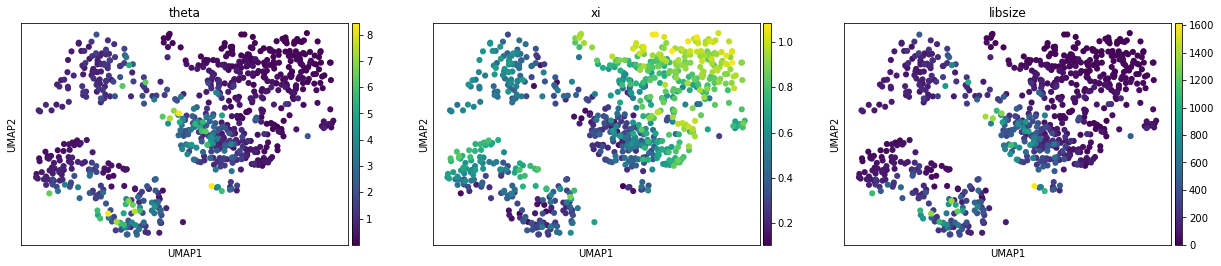

In [35]:
sc.pl.umap(adata_subsampled, color=['theta', 'xi', 'libsize'], ncols=3)

We implement K-means clusters on the mixture means
and compare with the results obtained from clustering on the
inferCNV data. Interestingly, we see presence of the purple and
yellow clones in the on_later treatment timepoint. This may suggest
either more noise in our model means, or stronger signal for these
clusters.

In [36]:
clones = KMeans(n_clusters=4, random_state=0).fit_predict(mixture_means)
adata_subsampled.obs["mix_mu_clones"] = clones

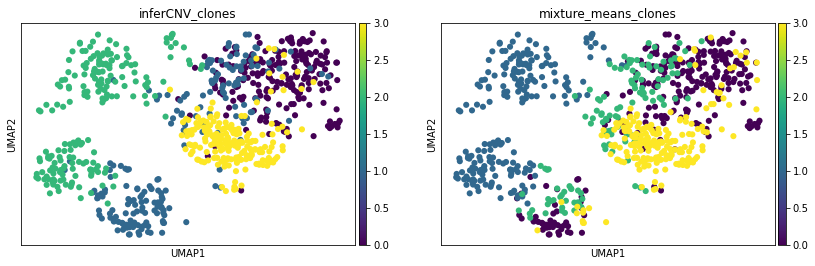

In [37]:
sc.pl.umap(adata_subsampled, color=['inferCNV_clones', 'mix_mu_clones'])

In [38]:
beta = mod_scHPF_fit.stan_variables()["beta"]
theta = mod_scHPF_fit.stan_variables()["theta"]

In [39]:
lambd = np.zeros(beta.shape)
for i in range(lambd.shape[0]):
    for j in range(lambd.shape[1]):
        lambd[i][j] = theta[i] * beta[i][j]

In [41]:
posteriors_all = []
for k in range(1000):
    posterior = np.zeros(lambd.shape)
    for i in range(lambd.shape[0]):
        for j in range(lambd.shape[1]):
            posterior[i][j] = np.random.poisson(lambd[i][j])
    posteriors_all.append(posterior)

In terms of statistical criticism, we began with posterior predictive
checks. Here we draw 1000 samples from the posterior and analyze how well
the model predictions match our actual data. We then look directly
at the lambda values obtained from the product of theta and beta
(defined below) for an alternative method of evaluating our model's
ability to represent the data. In both cases, we see good linear trends.

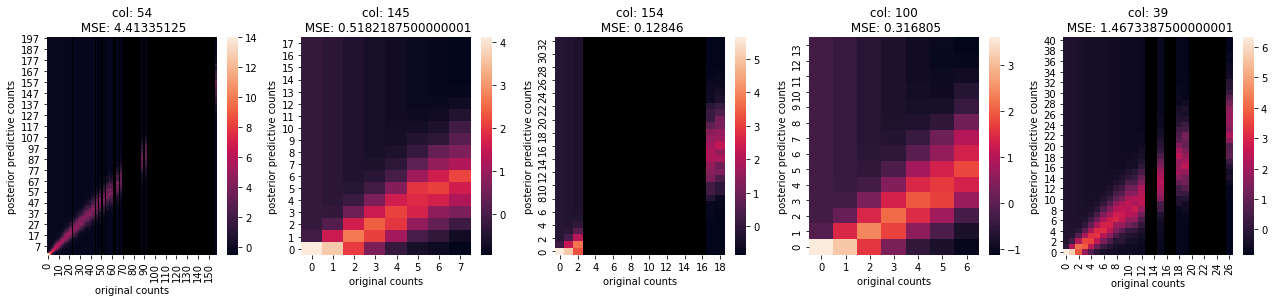

In [47]:
posteriors_all = np.asarray(posteriors_all)
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
ind = 0
rands = np.random.choice([i for i in range(200)], size=5, replace=False)
for col in rands:
    combined_x = []
    combined_y = []
    heatmap = np.zeros((int(max(posteriors_all[:, :, col].flatten())) + 1,
                        int(max(adata_subsampled.layers['counts'][:, col]))
                        + 1))
    max_post = int(max(posteriors_all[:, :, col].flatten()))
    for i in range(1000):
        combined_x.append(adata_subsampled.layers['counts'][:, col])
        combined_y.append(posteriors_all[i][:, col])
        for j in range(800):
            tmp_coord = int(adata_subsampled.layers['counts'][j, col])
            heatmap[max_post -
                    int(posteriors_all[i, j, col])][tmp_coord] += 1
    MSE = sklearn.metrics.mean_squared_error(combined_x, combined_y)
    hmap = pd.DataFrame(scipy.stats.zscore(heatmap))
    hmap.columns = [i for i in range(heatmap.shape[1])]
    hmap.index = np.flip([i for i in range(heatmap.shape[0])])
    g = sns.heatmap(hmap, ax=ax[ind])
    g.set_facecolor('black')
    g.set_xlabel("original counts")
    g.set_ylabel("posterior predictive counts")
    g.set_title("col: " + str(col) + "\n MSE: " + str(MSE))
    ind += 1

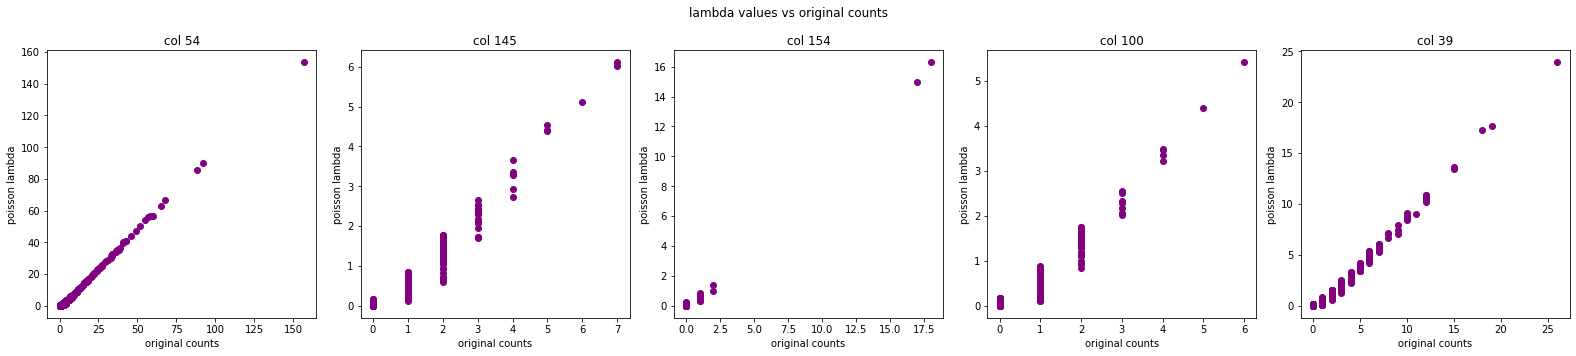

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(22, 5))
for i in range(5):
    x = adata_subsampled.layers['counts'][:, rands[i]]
    y = lambd[:, rands[i]]
    ax[i].scatter(x, y, c='purple')
    ax[i].set_xlabel("original counts")
    ax[i].set_ylabel("poisson lambda")
    ax[i].set_title("col " + str(rands[i]))
plt.suptitle("lambda values vs original counts")
plt.tight_layout()

Acknowledgments: Dr. Elham Azizi proposed our model and provided guidance,\
Nicolas Beltran assisted and provided guidance\
Yuan, et al, 2019 (original scHPF model):
https://doi.org/10.15252/msb.20188557 \
GMM code was obtained from online resources such as
https://maggielieu.com/ ,
the stan user guide, and others